# Synthetic Sample Task - Geometries


## Generating Samples

positive indices: [84955 85040 96419 65354 23026] 
negative indices: [31796 95356 70410 32462   754]
The first list indicates indices of swaps, second list indicates part (0 -> shape, 1 -> color)
swapped: [0] on part [0] for sample on row # 5
swapped: [0] on part [0] for sample on row # 6
swapped: [0] on part [1] for sample on row # 7
swapped: [10] on part [1] for sample on row # 8
swapped: [2] on part [0] for sample on row # 9


<AxesSubplot: xlabel='sequence index', ylabel='# of sample'>

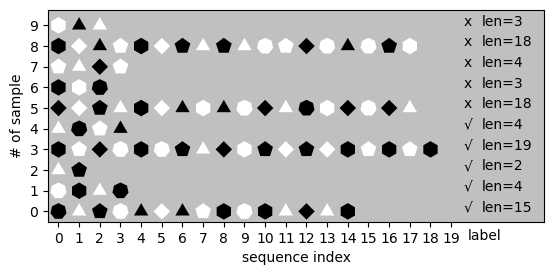

In [3]:
from geometries import generate_data, visualize

X, y, optional = generate_data(1e5, 1, return_len=True, return_indices=True)
visualize(X, y, **optional)

## Create Dataloader

In [295]:
import torch
from torch.utils.data import Dataset, DataLoader

max_seq_len = 20
hidden_size = 32
batch_size = 32
sample_len = 1e5

X, y = generate_data(sample_len, 0.3, max_len=max_seq_len)

# Define dataloader and load data
class Geometries(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y)
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

X_train, y_train, X_test, y_test = X[int(sample_len / 10):], y[int(sample_len / 10):], X[:int(sample_len / 10)], y[:int(sample_len / 10)]
training_data = Geometries(X_train, y_train)
test_data = Geometries(X_test, y_test)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)    

## Create Model

In [302]:
from torch import nn
from transformers import BertConfig, BertModel

config = BertConfig(vocab_size= 16, hidden_size = hidden_size, num_hidden_layers= 4, 
                    num_attention_heads= 4, intermediate_size= 64, 
                    max_position_embeddings= max_seq_len)
bert_encoder = BertModel(config)

class Geometries_Tokenizer():
    def __init__(self):
        pass
    
    def __call__(self, x : list):
        pass

class Classifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.tokenizer = Geometries_Tokenizer()
        self.bert = bert_encoder
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(nn.Linear(max_seq_len * hidden_size, 2), 
                                            nn.Softmax())      
        
    def foward(self, x):
        x = self.tokenizer(x)
        x = self.bert(x)
        logits = self.classifier(x)
        
        return logits
    
model = Classifier()


In [304]:
print(model)

Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(16, 32, padding_idx=0)
      (position_embeddings): Embedding(20, 32)
      (token_type_embeddings): Embedding(2, 32)
      (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=32, out_features=32, bias=True)
              (key): Linear(in_features=32, out_features=32, bias=True)
              (value): Linear(in_features=32, out_features=32, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=32, out_features=32, bias=True)
              (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
              (dro